## Trabajo Kafka

*Rubén Giménez, Mayra Russo, Guillermo Climent*

### 1. Introducción
El objetivo del presente trabajo es la creación de una arquitectura de Kafka capaz de realizar *streaming* en tiempo real de datos de la bolsa, para su posterior análisis y toma de decisiones en cuanto a inversiones de riesgo o atractivas.

Para tal fin, y tras haber considerado un amplio abanico de herramientas y APIs, se prodeció a utilizar la API del IEX.

#### 1.1. IEX Finance
El programa aquí presentado es capaz de obtener información en tiempo real a través de la API del Investors Exchange (IEX), una bolsa de valores creada con la misión de diseñar mercados más justos. Gracias a esta API se puede obtener información relevante de los *stocks* (compañías) presentes en dicha bolsa, como su histórico de valores, métricas de dichos valores o información general de los mismos.

#### 1.2. Compañías
La lista de los diferentes *stocks* se referencia en la API con símbolos únicos para cada compañía, los cuales se obtuvieron haciendo una selección de todos los presentes en la siguiente página web: https://iextrading.com/trading/eligible-symbols/

Dicha selección se hizo para poder manejar la arquitectura que se planteará a continuación, con un *topic* para cada compañía: contando con recursos limitados, lanzar un número tan elevado de *topics* supondría problemas de memoria.

Se pueden encontrar los símbolos y compañías utilizados en: <a href="data/companies.csv">data/companies.csv</a>

### 2.  Arquitectura

#### 2.1. Obtención de los datos con la IEX API

Como se ha comentado en el apartado anterior, la IEX API nos permite obtener el histórico para compañía o *stock*, gracias a la función *get_historical_data*. Ésta es, por tanto, nuestra fuente de datos con la queremos hacer *streaming* para cada uno de los usuarios que lo necesiten, previa demanda usando el *bot* de Telegram.

#### 2.2. Virtualización con Docker Compose

Con el fin de tener una arquitectura ligera, compartimentada y, por tanto, agnóstica del sistema operativo, se ha decidido utilizar la herramienta Docker Compose. Gracias a la virtualización que ofrece, basada en el lanzamiento de diferentes contenedores, se puede replicar de manera sencilla en diferentes dispositivos a la vez que se obtiene un sistema relativamente ligero en cuanto a consumo de recursos.

La arquitectura del sistema de contenedores se puede consultar en el archivo YAML de configuración: <a href="docker-compose.yml">docker-compose.yml</a>

<font color="red">EXPLICAR NUM FINAL DE ZK Y BROKERS</font>

#### 2.3. *Streaming* con Kafka

Una vez lanzado los contenedores, el sistema actualizará los datos para cada compañía diariamente, aunque se plantea la mejora en un futuro de actualizar los datos cada hora para una mayor precisión del modelo. Dicha actualización se realizará mediante la IEX API, que mandará los datos al sistema de Kafka mediante el productor.

Posteriormente, y en el momento del día que se requiera, el modelo o los usuarios (mediante el *bot*) podrán obtener dicha información mediante la clase de consumidor, que obtendrá la información del histórico de todas las compañías en el *topic*. Otra posible mejora sería lanzar un *topic* por cada compañía, aunque al nivel actual de trabajo y recursos no lo hemos considerado necesario por suponer una bajada en el rendimiento del sistema, ya que no hay tantos datos que almacenar ni se establece una división lógica *a priori* de las diferentes compañías en diferentes *topics*.

#### 2.4. Modelos de series temporales

En un futuro, se pretende implementar un modelo de series temporales para cada una de las compañías que permita tomar decisiones en cuanto a compra-venta en la bolsa de valores. Estos modelos estarían implementados en un compartimento diferente al del bot, pero conectado a él para facilitar el mantenimiento y la ligereza tanto del *bot* como de los modelos.

#### 2.5. Sistema de alertas mediante bot

Finalmente, el acceso tanto a la información de los *stocks* como a las predicciones de los modelos se realizaría mediante el *bot* de Telegram, que proporcionaría una interfaz amigable y fácil para la toma de decisiones de los usuarios.

### 3. Parámetros de funcionamiento
<font color="red">
Poner lo de un topic por compañia, tres brokers, tres zookeepers, particiones y replicación topics, análisis downstream
Un topic por compañía NO: mejor tener uno sólo

Explicar por encima cada parámetro!!!!!!!

Ver todos los parámetros
</font>

#### 3.1. Número de *brokers*

Se ha decidido establecer el número de *brokers* a un máximo de 3 para aumentar la tolerancia a fallos del sistema sin excederse en el número de los mismos. En cuanto un *broker* falle, otro se ocupará su lugar para evitar cortes en el *streaming* y, aún si fallará el segundo, habría un tercero para evitar la parada de la aplicación. Aumentar a más de 3 supone un número demasiado elevado para nuestro trabajo.

#### 3.2. Número de *zookeepers*

Por otra parte, cabe destacar el número impar de *zookeepers* para evitar empates a la hora de elegir al líder, en nuestro caso 3.

#### 3.3. Número de particiones por *topic*

También se ha decidido establecer el número de particiones del *topic* a 3 para seguir la misma regla que en los apartados anteriores. La justificación del uso de un sólo tópic se puede encontrar en el apartado anterior "2.3. *Streaming* con Kafka".

#### 3.4. Factor de replicación de los *topics*

Misma actuación que en los apartados anteriores: un factor de replicación de 3, aún siendo un poco excesivo, evitará con una alta probabilidad la pérdida de datos.

#### 3.5. Número de horas hasta eliminación de los mensajes

En este caso, hemos optado por un tiempo menor ya que los datos de bolsa son bastante volátiles y el tiempo útil de cada semana son cinco días. Por tanto, se ha establecido el tiempo de eliminación a 120 horas (5 días) ya que asumimos que no se requieren estos datos una vez guardados en el sistema y realizado la predicción.

#### 3.6. Número de bytes hasta eliminación de los logs

Se ha reducido el número de bytes hasta 1e6 (1 GB) para evitar una sobrecarga innecesaria del ordenador.

### 4.  El código

#### 4.1. Inicialización
##### 4.1.1. Librerías necesarias

In [1]:
import pandas as pd

import json

from kafka import KafkaClient, KafkaProducer, KafkaConsumer

from datetime import datetime, timedelta

from iexfinance.stocks import get_historical_data
from iexfinance.utils.exceptions import IEXSymbolError

import matplotlib.pyplot as plt
import seaborn as sns

from utils.stdout import format_stdout

##### 4.1.2. Parámetros de funcionamiento
En este bloque de código se definen los parámetros de funcionamiento de Kafka: las direcciones de los *brokers*, el nombre del *topic*, el número de particiones de cada *topic* y su factor de replicación.

Además, también se establece el número de días de histórico que se quiere obtener para cada compañía.

In [2]:
# Kafka config
BOOTSTRAP_SERVERS = ['localhost:9092', 'localhost:9093', 'localhost:9094']
TOPIC_NAME = 'iexfinance'

# Stocks config
STOCK_DAYS = 365

##### 4.1.3. Carga de los símbolos de las diferentes compañías

En nuestro caso, se ha decidido fijar el número de compañías diferentes a 5 para evitar la sobrecarga del sistema:

In [3]:
companies = pd.read_csv('data/companies.csv', header=0, sep=';', encoding='utf-8')
symbols = companies.Symbol.values.tolist()[:5]

print(format_stdout('SYMBOLS'), ', '.join(symbols[:10] + ['...']))

[SYMBOLS  ] LFC, CX, CMCSA, GSH, ABBV, ...


##### 4.1.4. Creación del *topic*

```{bash}
kafka-topics --zookeeper localhost:2181 --create --topic iexfinance --replication-factor 3 --partitions 3
```

Nota: si se desea borrar el *topic* para reiniciar el sistema, se puede hacer mediante el siguiente comando:

```{bash}
kafka-topics --zookeeper localhost:2181 --delete --topic iexfinance
```

No obstante, para ello hace falta asegurarse de que la variable **delete.topic.enable** está definida como **true** en el archivo *server.properties*.

##### 4.1.5. Confirmación del estado del sistema

In [4]:
kafka_client = KafkaClient(BOOTSTRAP_SERVERS)

print(format_stdout('BROKERS'))
tmp = [print(elem) for elem in sorted(list(kafka_client.brokers.values()))]

print()
print(format_stdout('TOPICS'))
tmp = [print(elem) for elem in sorted(kafka_client.topics)]

print()
print(format_stdout('PARITIONS'))
tmp = [print(elem) for elem in sorted(kafka_client.topic_partitions.items())]

print()
print(format_stdout('TIMEOUT'), kafka_client.timeout)

[BROKERS  ]
BrokerMetadata(nodeId=1, host='127.0.0.1', port=9092, rack=None)
BrokerMetadata(nodeId=2, host='127.0.0.1', port=9093, rack=None)
BrokerMetadata(nodeId=3, host='127.0.0.1', port=9094, rack=None)

[TOPICS   ]
__confluent.support.metrics
iexfinance

[PARITIONS]
('__confluent.support.metrics', {0: 1})
('iexfinance', {0: 1, 2: 3, 1: 2})

[TIMEOUT  ] 120


#### 4.2. Publicación en el topic

In [5]:
producer = KafkaProducer(
    bootstrap_servers=BOOTSTRAP_SERVERS,
    value_serializer=lambda v: json.dumps(v).encode('utf-8'),
)

producer

In [6]:
end = datetime.today()
start = end - timedelta(days=STOCK_DAYS)

for symbol in symbols:
    try:
        historic = get_historical_data(
            symbol, start, end, output_format='json'
        )
        ack = producer.send(TOPIC_NAME, {symbol: historic})
        print(format_stdout('SENT'), symbol)

    except IEXSymbolError:
        print(
            format_stdout('ERROR'),
            '{} stock not found'.format(symbol)
        )

producer.flush()

[SENT     ] LFC
[SENT     ] CX
[SENT     ] CMCSA
[SENT     ] GSH
[SENT     ] ABBV


#### 4.3. *Streaming* de los históricos para cada compañía

In [7]:
consumer = KafkaConsumer(
    TOPIC_NAME,
    group_id=None,
    bootstrap_servers=BOOTSTRAP_SERVERS,
#     auto_offset_reset='earliest',
    enable_auto_commit=True,
    consumer_timeout_ms=5000,
    value_deserializer=lambda v: json.loads(v.decode('utf-8'))
)

consumer

Consumimos los mensajes del topic:

In [8]:
# NOTE: see the following link explaining why the two first lines are needed: https://github.com/dpkp/kafka-python/issues/601

consumer.topics()
consumer.seek_to_beginning()

historic_list = []
for message in consumer:
    historic_list.append(message)

historic_list[0]

ConsumerRecord(topic='iexfinance', partition=2, offset=0, timestamp=1558794593138, timestamp_type=0, key=None, value={'ABBV': {'2018-05-25': {'open': 97.6753, 'high': 98.487, 'low': 95.0589, 'close': 96.5199, 'volume': 25301660}, '2018-05-29': {'open': 95.7464, 'high': 97.0069, 'low': 94.4669, 'close': 94.9825, 'volume': 25494690}, '2018-05-30': {'open': 97.2647, 'high': 98.5032, 'low': 96.2812, 'close': 98.3628, 'volume': 31273360}, '2018-05-31': {'open': 96.3767, 'high': 96.539, 'low': 94.0563, 'close': 94.4764, 'volume': 18910905}, '2018-06-01': {'open': 93.512, 'high': 94.9443, 'low': 93.4833, 'close': 93.6266, 'volume': 14837309}, '2018-06-04': {'open': 94.0372, 'high': 94.973, 'low': 93.216, 'close': 94.6292, 'volume': 10922502}, '2018-06-05': {'open': 94.6388, 'high': 95.8085, 'low': 94.3056, 'close': 94.7629, 'volume': 10198997}, '2018-06-06': {'open': 94.7724, 'high': 95.4791, 'low': 93.8844, 'close': 95.4695, 'volume': 4933473}, '2018-06-07': {'open': 95.7273, 'high': 95.8037

#### 4.3. Formato de los datos para posterior análisis

Los datos se deben transformar a un *dataframe* en formato *long* para poder ser procesados por los algoritmos de análisis de series temporales.

In [9]:
results_df = pd.DataFrame()

# Reorganize data into a long format
for historic in historic_list:
    for symbol, values in historic.value.items():
        for date, prices in values.items():
            row = pd.Series(prices).to_frame().T
            
            row['stock'] = symbol
            row['date'] = date
    
            results_df = pd.concat([results_df, row], axis=0)

# Reorder columns
results_df = results_df[['stock', 'date', 'open', 'high', 'low', 'close']]
        
results_df.head()

,stock,date,open,high,low,close
0,ABBV,2018-05-25,97.6753,98.4870,95.0589,96.5199
0,ABBV,2018-05-29,95.7464,97.0069,94.4669,94.9825
0,ABBV,2018-05-30,97.2647,98.5032,96.2812,98.3628
0,ABBV,2018-05-31,96.3767,96.5390,94.0563,94.4764
0,ABBV,2018-06-01,93.5120,94.9443,93.4833,93.6266


#### 4.4. Visualización de los datos obtenidos

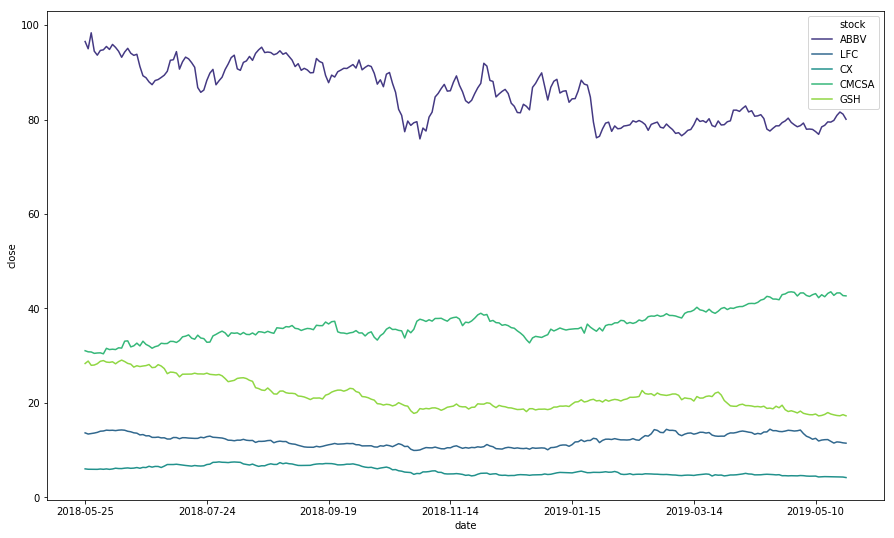

In [10]:
plt.figure(figsize=(15,9))
ax = sns.lineplot(x='date', y='close', hue='stock', data=results_df, palette='viridis')
ax.xaxis.set_major_locator(plt.MaxNLocator(7))

### 5.  Pruebas de funcionamiento

In [11]:
# TODO